# Variational ansatz-based quantum simulation of imaginary time evolution

Paper by: Sam McArdle, Tyson Jones, Suguru Endo, Ying Li, Simon C. Benjamin and Xiao Yuan

Link to paper: https://www.nature.com/articles/s41534-019-0187-2

Notebook by: [Óscar Amaro](https://github.com/OsAmaro) 2024

See [Qiskit-Algorithms tutorial 11](https://github.com/qiskit-community/qiskit-algorithms/blob/main/docs/tutorials/11_VarQTE.ipynb)

_Summary:_ Qiskit's VarQITE implementation to obtain Ground-State of a 2-qubit Hamiltonian, compared with "exact" SciPy calculation.

_Observation:_ The initial VarQITE variational parameters are not explicit in the paper, so we take random values. This can change the results of figure 2.

In [1]:
import numpy as np
from numpy import log, log10, sin, cos, exp, sqrt, pi
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import json

from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit_algorithms import TimeEvolutionProblem, VarQITE, SciPyImaginaryEvolver
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector, SparsePauliOp

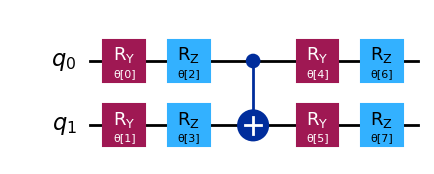

In [2]:
# define hamiltonian by hand
"""
# Define Pauli matrices
#op0 = np.array([[1.0, 0.0], [0, 0]], dtype=complex)
#op3 = np.array([[0.0, 0.0], [0, -1]], dtype=complex)
Id = np.array([[1.0, 0], [0, 1]], dtype=complex)
X = np.array([[0.0, 1], [1, 0]], dtype=complex)
Y = np.array([[0.0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1.0, 0], [0, -1]], dtype=complex)
#
g0 = 0.2252; g1 = 0.3435; g2 = -0.4347; g3= 0.5716; g4 = 0.0910; g5 = 0.0910;
hamiltonian = g0*np.kron(Id,Id) + g1*np.kron(Z,Id) + g2*np.kron(Id,Z) + g3*np.kron(Z,Z) + g4*np.kron(Y,Y) + g5*np.kron(X,X)
"""

hamiltonian = SparsePauliOp(["II", "ZI", "IZ", "ZZ", "YY", "XX"], coeffs=[0.2252, 0.3435, -0.4347, 0.5716, 0.0910, 0.0910])
ansatz = EfficientSU2(hamiltonian.num_qubits, reps=1)
ansatz.decompose().draw("mpl")

In [3]:
# VarQITE
#### initial ansatz parameters
init_param_values = {}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = np.random.rand()*(2*pi) #np.pi / 2
#### define VarQITE
var_principle = ImaginaryMcLachlanPrinciple()
#### time evolution problem
time = 4.0
aux_ops = [hamiltonian]
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
#### evolve with VarQITE >>>> takes some time
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result = var_qite.evolve(evolution_problem)

In [4]:
# exact - scipy
#### assign initial state
init_state = Statevector(ansatz.assign_parameters(init_param_values))
#### evolve exactly with scipy
evolution_problem = TimeEvolutionProblem(
    hamiltonian, time, initial_state=init_state, aux_operators=aux_ops
)
exact_evol = SciPyImaginaryEvolver(num_timesteps=401)
sol = exact_evol.evolve(evolution_problem)

# save results to arrays
h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])
exact_h_exp_val = sol.observables[0][0].real

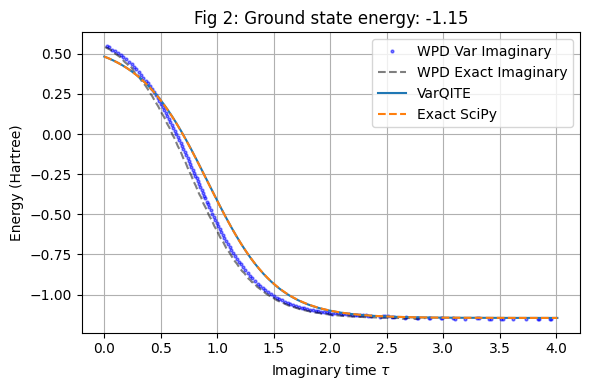

In [5]:
# fluctuations in the dataWPD will be due to uncertainty in selecting points in WPD
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

### fig 3
f = open('dataWPD/fig2/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='blue', markersize=2, label='WPD Var Imaginary',alpha=0.5)
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'k--', markersize=2, label='WPD Exact Imaginary',alpha=0.5)

# plot simulation results
times = evolution_result.times
plt.plot(times, h_exp_val, label="VarQITE")
plt.plot(times, exact_h_exp_val, label="Exact SciPy", linestyle="--")

plt.title(r"Fig 2: Ground state energy: {:.2f}".format(h_exp_val[-1]))
plt.xlabel(r'Imaginary time $\tau$')
plt.ylabel(r'Energy (Hartree)')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('fig2_dataWPD.pdf', transparent=True)
plt.show()